# Telco Customer Churn

# I. Packages
Reading in the packages needed for the project.

In [1]:
import pandas as pd
import numpy as np
import h2o
import seaborn as sns
import matplotlib.pyplot as plt
import utils as ut

# set pandas options 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 999)

# II. Data Quality Check & Data Preparation
Checking the quality of the dataset and correcting potential errors.

In [2]:
# read in the dataset
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',', decimal='.')
# make the column names unified 
df.rename(columns={'customerID': 'customerId', 
                   'SeniorCitizen': 'seniorCitizen',
                   'Partner': 'partner' ,
                   'Dependents': 'dependents',
                   'tenure': 'customerLifetimeMonths',
                   'PhoneService': 'phoneService',
                   'MultipleLines': 'multipleLines',
                   'InternetService': 'internetService',
                   'OnlineSecurity': 'onlineSecurity',
                   'OnlineBackup': 'onlineBackup',
                   'DeviceProtection': 'deviceProtection', 
                   'TechSupport': 'techSupport',
                   'StreamingTV': 'streamingTv',
                   'StreamingMovies': 'streamingMovies',
                   'Contract': 'contract', 
                   'PaperlessBilling': 'paperlessBilling', 
                   'PaymentMethod': 'paymentMethod',
                   'MonthlyCharges': 'monthlyCharges',
                   'TotalCharges': 'totalCharges',
                   'Churn': 'churn'}, inplace=True)

print('The dataset has', df.shape[0] , 'rows and', df.shape[1], 'columns.')

The dataset has 7043 rows and 21 columns.


In [3]:
df.sample(5)

,customerId,gender,seniorCitizen,partner,dependents,customerLifetimeMonths,phoneService,multipleLines,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTv,streamingMovies,contract,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,churn
2096,0761-AETCS,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.30,19.3,Yes
6651,2038-YSEZE,Female,0,No,No,29,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,67.45,1801.1,No
3690,6038-GCYEC,Female,0,No,No,24,No,No phone service,DSL,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),54.15,1240.25,Yes
5211,8382-SHQEH,Female,0,Yes,No,8,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.90,764.95,Yes
5279,0394-YONDK,Male,0,Yes,Yes,70,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.15,1790.15,No


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerId              7043 non-null   object 
 1   gender                  7043 non-null   object 
 2   seniorCitizen           7043 non-null   int64  
 3   partner                 7043 non-null   object 
 4   dependents              7043 non-null   object 
 5   customerLifetimeMonths  7043 non-null   int64  
 6   phoneService            7043 non-null   object 
 7   multipleLines           7043 non-null   object 
 8   internetService         7043 non-null   object 
 9   onlineSecurity          7043 non-null   object 
 10  onlineBackup            7043 non-null   object 
 11  deviceProtection        7043 non-null   object 
 12  techSupport             7043 non-null   object 
 13  streamingTv             7043 non-null   object 
 14  streamingMovies         7043 non-null   

## II.1. Looking for missing values

In [5]:
# check number of rows with missing values 
print('Number of rows with missing data:', df[df.isnull().any(axis=1)].shape[0]) 
print('Number of rows with missing TotalCharge:', df[df.totalCharges == " "].shape[0])

Number of rows with missing data: 0
Number of rows with missing TotalCharge: 11


There are only 11 cases where the TotalCharge is missing, which is less than 0.2% of the whole dataset, so I chose to eleminate these customers from the analysis.

In [6]:
df = df[df.totalCharges != " "]
df['totalCharges'] = df['totalCharges'].astype(float)
print('The dataset has', df.shape[0] , 'rows and', df.shape[1], 'columns.')

The dataset has 7032 rows and 21 columns.


## II.2. Looking for logical errors in the dataset


In [7]:
print('Number of rows with duplicated customerID:', df[df.groupby('customerId')['customerId'].transform('size') > 1].shape[0]) 
print('Number of rows with bigger MonthlyCharges than TotalCharges:', df[df.monthlyCharges > df.totalCharges].shape[0])

Number of rows with duplicated customerID: 0
Number of rows with bigger MonthlyCharges than TotalCharges: 0


In [8]:
print('Nbr of rows with no internet service, BUT with online services:')
for service in ['onlineSecurity', 'onlineBackup', 'deviceProtection', 'streamingTv', 'streamingMovies']:
    print(service, ':', df[(df.internetService != 'No') & (df[service] == 'No internet service')].shape[0])
    

Nbr of rows with no internet service, BUT with online services:
onlineSecurity : 0
onlineBackup : 0
deviceProtection : 0
streamingTv : 0
streamingMovies : 0


## II.3. Creating new variables


In [9]:
# mapping the values of SeniorCitizen
df.seniorCitizen = df.seniorCitizen.map({1: 'Yes', 0: 'No'})
# creating new variables 
df['paymentIsElectronic'] = np.where(df.paymentMethod.str.contains('Mailed', na=False), 'No', 'Yes')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerId              7032 non-null   object 
 1   gender                  7032 non-null   object 
 2   seniorCitizen           7032 non-null   object 
 3   partner                 7032 non-null   object 
 4   dependents              7032 non-null   object 
 5   customerLifetimeMonths  7032 non-null   int64  
 6   phoneService            7032 non-null   object 
 7   multipleLines           7032 non-null   object 
 8   internetService         7032 non-null   object 
 9   onlineSecurity          7032 non-null   object 
 10  onlineBackup            7032 non-null   object 
 11  deviceProtection        7032 non-null   object 
 12  techSupport             7032 non-null   object 
 13  streamingTv             7032 non-null   object 
 14  streamingMovies         7032 non-null   

# III. Exploratory Data Analysis (EDA)

In [11]:
all_vars = list(df.columns)
all_vars.remove('churn')
all_vars.remove('customerId')

num_var_list = list(df.select_dtypes(include=['float']).columns)
cat_var_list = list(df[all_vars].select_dtypes(include=['object']).columns)

## III.1. Numerical variables
## Descriptive statistics

In [12]:
ut.create_descriptive_stat(df,num_var_list)

,monthlyCharges,totalCharges
min,18.25,18.80
max,118.75,8684.80
mean,64.80,2283.30
mode,20.05,20.20
median,70.35,1397.48
10%,20.05,84.60
20%,25.05,267.07
30%,45.90,552.00
40%,58.92,944.17
50%,70.35,1397.48


### Key takeaways

- most of the customers in the dataset are new customers (mode of CustomerLifetimeMonths = 1)
- Charges:
    * the monthlyCharges and the totalCharges can be very different, they vary between very small and quite big values
    * These values can depend on:
        * the service the customer is paying for (internet/and or telephone service)
        * only in the case ot totalCharges: how long the customer is paying for a service for the company



## Density of churn

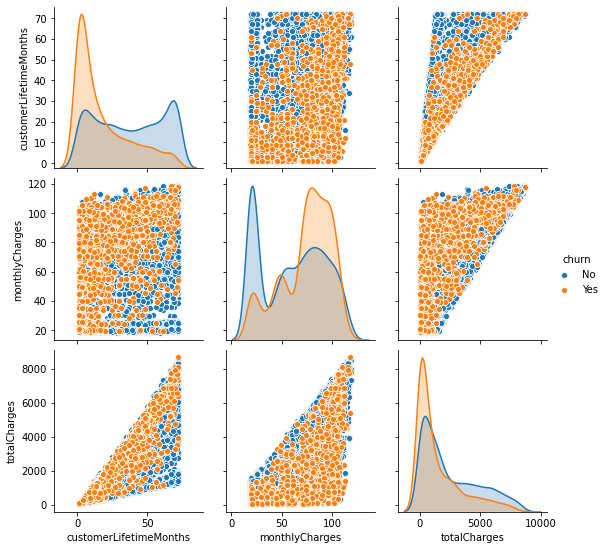

In [13]:
sns.pairplot(df, hue="churn")

#### Key takeaways
- most of the churn happens among new customers

## III.2. Categorical variables
### Denstiy of churn

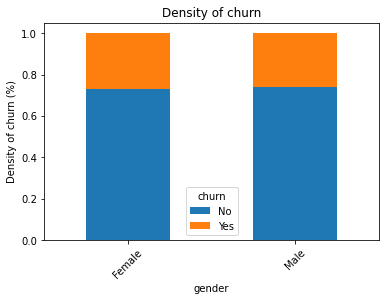

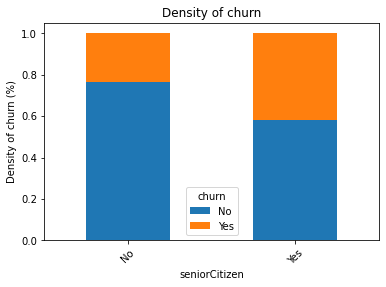

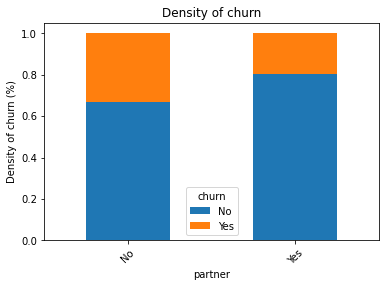

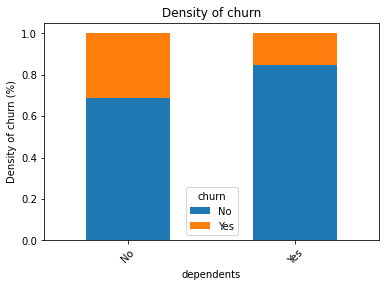

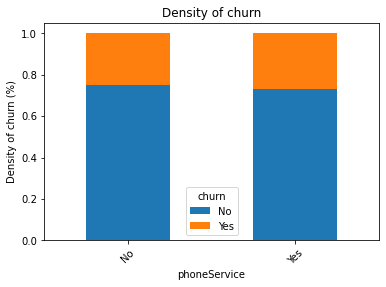

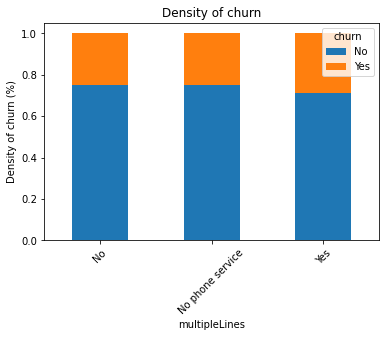

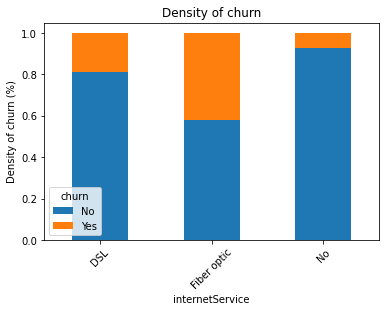

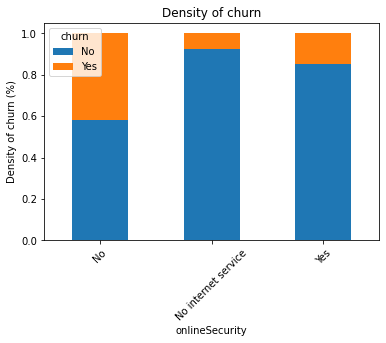

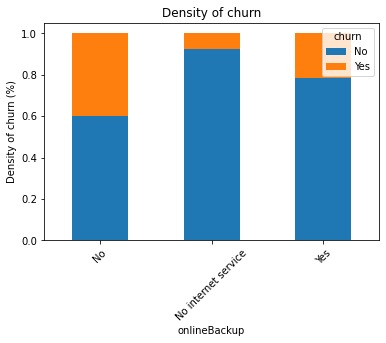

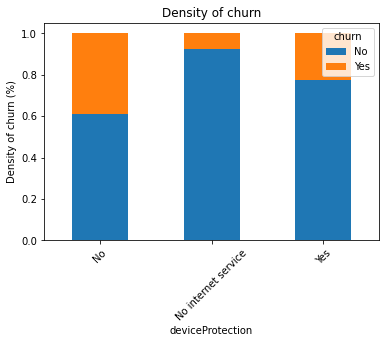

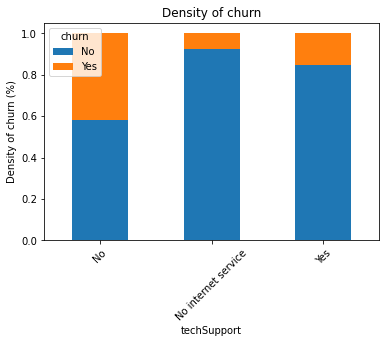

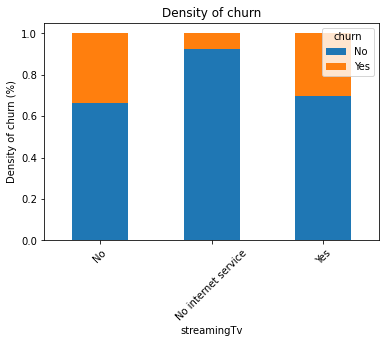

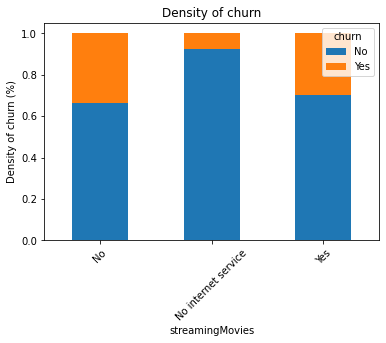

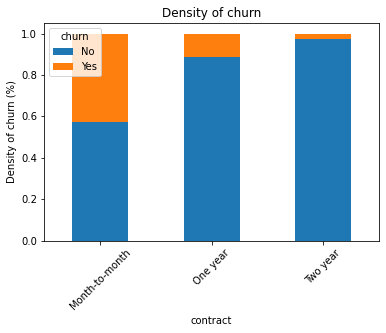

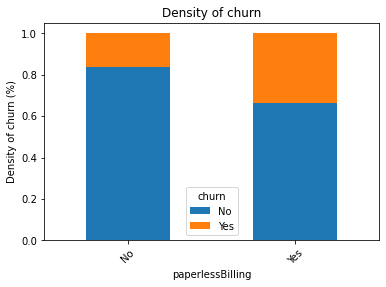

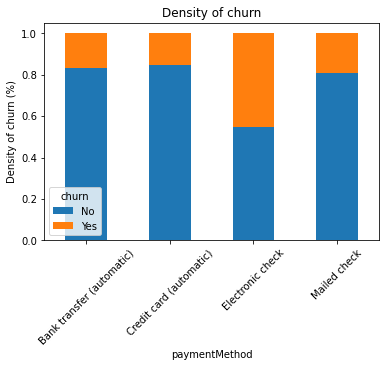

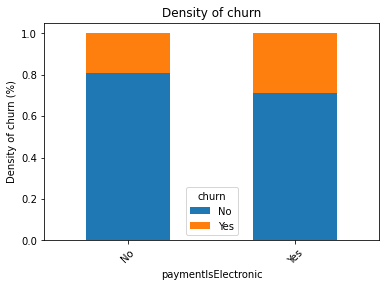

In [14]:
for var in cat_var_list:
    ut.plot_full_stacked_density(df, 'churn', var, 'bar')

### Key takeaways
At first glance, the following custmers are more likely to churn:

- who have internet service,
    * mainly the ones with Fiber Optic service
    * and the ones who do not have any additional services
- who has month-to-month contract
- the ones who pay their invoces with electronic check
- who are senior citizens

### III.3. Correlation between variables¶
Checking the Pearson correlation between each variable and eliminating one of the variables from highly correlated variable pairs.

In [15]:
corr_all_vars = ut.calc_pearson_correlation(df, all_vars)
ut.select_by_correlation_threshold(corr_all_vars, 0.6)

,variable_1,variable_2,correlation
1,streamingMovies,streamingTv,0.809507
2,onlineSecurity,techSupport,0.790951
3,techSupport,deviceProtection,0.767659
4,streamingMovies,deviceProtection,0.766635
5,streamingTv,deviceProtection,0.762742
6,onlineSecurity,deviceProtection,0.748684
7,techSupport,streamingTv,0.737211
8,techSupport,streamingMovies,0.737126
9,internetService,streamingTv,0.712715
10,internetService,streamingMovies,0.708336


In [16]:
# eliminate highly correlated variables 
reduced_vars = all_vars.copy() 
for i in ['streamingMovies','streamingTv', 'onlineBackup','deviceProtection', 'onlineSecurity', 'techSupport', 'phoneService']: 
    reduced_vars.remove(i)

#### Correlation between variables

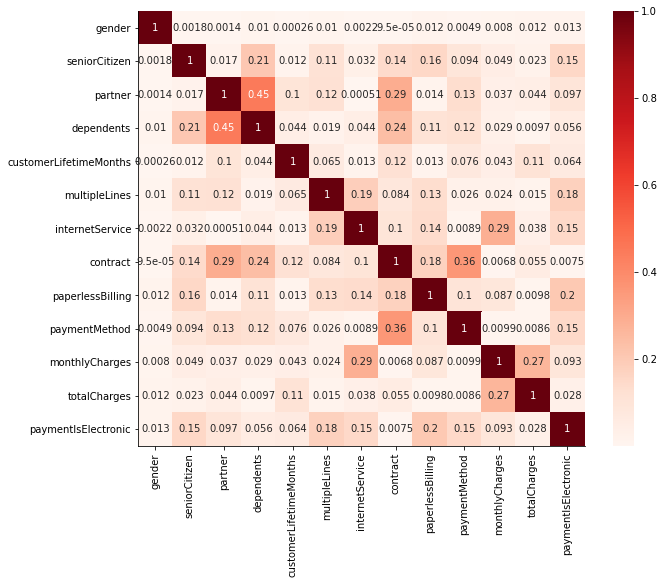

In [17]:
corr_reduced =  ut.calc_pearson_correlation(df, reduced_vars)
hm = sns.heatmap(corr_reduced, annot=True, cmap=plt.cm.Reds) 
sns.despine()
hm.figure.set_size_inches(10, 8)

plt.show()

## IV. Variable Selection
Selecting the variables with the highest predictive power.

**Methodology:** <br> 
Building a GBM, a GLM and a DRF model with all potential variables to select the ones with the highest predivtice power based on their variable importances (which is based on forward selection). Selecting the TOP 5 variables from each model's result.

In [18]:
# initalizing h2o 
h2o.init(ip="localhost", port=54323, max_mem_size=1)

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\hargi\anaconda3\envs\telco_customer_churn_\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\hargi\AppData\Local\Temp\tmppcd4zlhg
  JVM stdout: C:\Users\hargi\AppData\Local\Temp\tmppcd4zlhg\h2o_hargi_started_from_python.out
  JVM stderr: C:\Users\hargi\AppData\Local\Temp\tmppcd4zlhg\h2o_hargi_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Prague
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_hargi_g08mrt
H2O cluster total nodes:,1
H2O cluster free memory:,1 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [19]:
# convert pandas DataFrame to h2o frame
df_h2o = h2o.H2OFrame(df)
# check data types
df_h2o.types

Parse progress: |█████████████████████████████████████████████████████████| 100%


{'customerId': 'string',
 'gender': 'enum',
 'seniorCitizen': 'enum',
 'partner': 'enum',
 'dependents': 'enum',
 'customerLifetimeMonths': 'int',
 'phoneService': 'enum',
 'multipleLines': 'enum',
 'internetService': 'enum',
 'onlineSecurity': 'enum',
 'onlineBackup': 'enum',
 'deviceProtection': 'enum',
 'techSupport': 'enum',
 'streamingTv': 'enum',
 'streamingMovies': 'enum',
 'contract': 'enum',
 'paperlessBilling': 'enum',
 'paymentMethod': 'enum',
 'monthlyCharges': 'real',
 'totalCharges': 'real',
 'churn': 'enum',
 'paymentIsElectronic': 'enum'}

In [20]:
# splitting frame into test + train 
train, test = df_h2o.split_frame(ratios=[0.7], seed=1234)

print('Shape of TRAIN:', train.shape) 
print('Shape of TEST:', test.shape) 

Shape of TRAIN: (4939, 22)
Shape of TEST: (2093, 22)


In [21]:
target = "churn"
modelling_vars = reduced_vars.copy()
print('Nbr of all modelling variables: ', len(modelling_vars))

nfolds = 5
n = 5

Nbr of all modelling variables:  13


### IV.1. Modelling with all variables
#### GBM

gbm Model Build progress: |███████████████████████████████████████████████| 100%


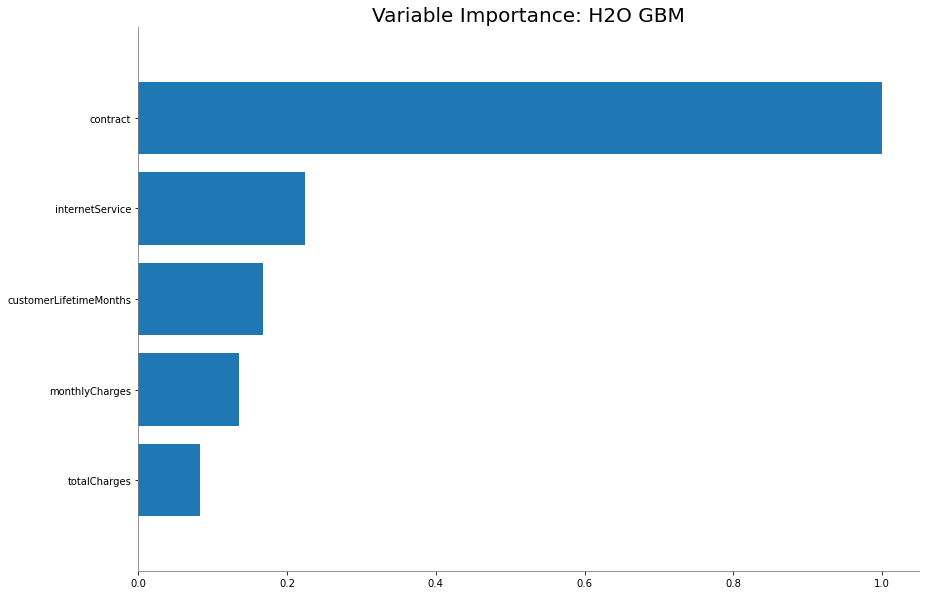

In [22]:
model_gbm_varsel, result_gbm = ut.variable_selection(modelling_vars, target, train, nfolds, n, 'GBM')
# plot variable importance 
model_gbm_varsel.varimp_plot(num_of_features=n)

#### GLM

glm Model Build progress: |███████████████████████████████████████████████| 100%


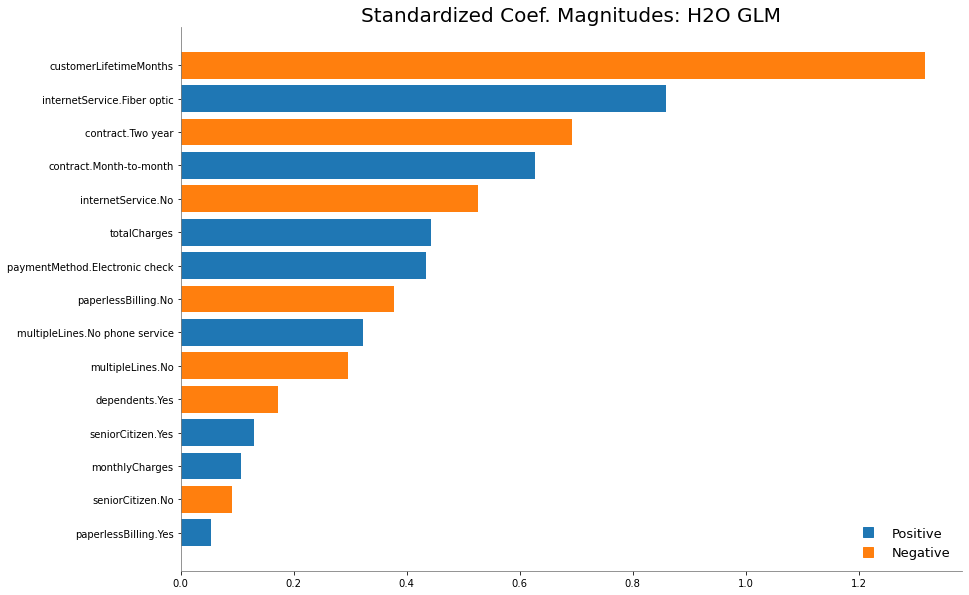

In [23]:
model_glm_varsel, result_glm = ut.variable_selection(modelling_vars, target, train, nfolds, n, 'GLM')
# plot variable importance 
model_glm_varsel.std_coef_plot(num_of_features=n + 10)

#### DRF

drf Model Build progress: |███████████████████████████████████████████████| 100%


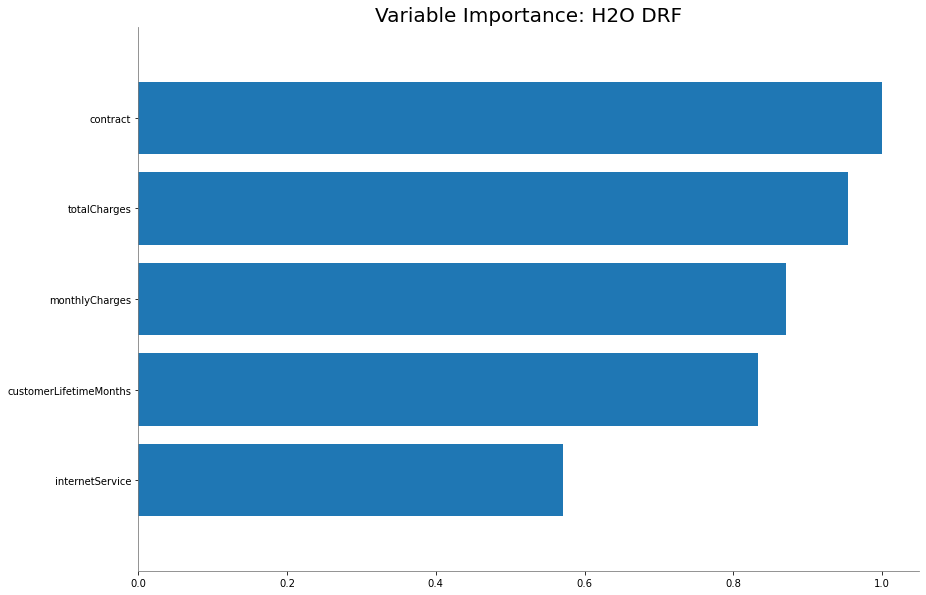

In [24]:
model_drf_varsel, result_drf = ut.variable_selection(modelling_vars, target, train, nfolds, n, 'DRF')
# plot variable importance 
model_drf_varsel.varimp_plot(num_of_features=n)

#### Result

In [25]:
# selected variables
selected = set(result_gbm + result_glm + result_drf)
selected_nbr = len(selected)

print('Nbr of selected variables:' , selected_nbr)
print('Selected variables: ', selected)

Nbr of selected variables: 7
Selected variables:  {'monthlyCharges', 'customerLifetimeMonths', 'contract', 'multipleLines', 'paymentMethod', 'totalCharges', 'internetService'}


### IV.2. Testing selected variables - base line models
Testing the model performance with selected variables per each model type. All the modelling parameters are set to default.

In [26]:
model_gbm_test, model_glm_test, model_drf_test = ut.modelling_for_testing_variables(target, selected, train, nfolds)
test_model_list = [model_gbm_test, model_glm_test, model_drf_test]
compare_varsel_df = ut.result_comparison(test_model_list, test, target)
compare_varsel_df

gbm Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


,Model,AUC,Customer Nbr,Target Nbr,Cum Capture Rate TOP 10%,Cum Response Rate TOP 10%,Target Found TOP 10%,Cum Capture Rate TOP 20%,Cum Response Rate TOP 20%,Target Found TOP 20%
0,GBM,0.83,2093,550,0.28,0.73,154,0.48,0.63,264
1,GLM,0.83,2093,550,0.29,0.75,159,0.48,0.63,264
2,DRF,0.81,2093,550,0.26,0.68,143,0.45,0.59,247


## V. Parameter Tuning
Tuning the GBM and GLM model's hyperparameters (as they had nearly the same results) with the help of grid search.

The best model should have the highest AUC value on the test set.

### V.1. GBM
1. Finding the optimal max_depth parameter

In [27]:
best_gbm_max_depth, gbm_grid_max_depth = ut.gbm_grid_search_max_depth(selected, target, train, test, nfolds)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [28]:
# the result of the grid search 
gbm_grid_max_depth

,,max_depth,auc
0,,3,0.8431605225790508
1,,4,0.8423231017973604
2,,5,0.8396313547430457
3,,6,0.8361999924603856
4,,7,0.8330950326507189
5,,8,0.8303534403679331


2. Finding all the other optimal hyperparametrs

In [29]:
# show top 5 models 
show_top = 5 

In [30]:
max_depth = 3
ntrees_list = [50, 100, 150, 200]
min_rows_list = [150, 300, 500, 1000]

best_model_gbm, gbm_grid = ut.gbm_grid_search(selected, target, train,  test, nfolds, max_depth, ntrees_list, min_rows_list, show_top)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [31]:
# the results for the TOP 5 models 
gbm_grid

,,col_sample_rate,col_sample_rate_change_per_level,col_sample_rate_per_tree,histogram_type,learn_rate,learn_rate_annealing,min_rows,min_split_improvement,ntrees,sample_rate,auc
0,,1.0,0.5,0.9,QuantilesGlobal,0.35,0.95,500.0,1.0E-5,150,0.9,0.84508029689326
1,,0.3,1.5,0.6,QuantilesGlobal,0.08,0.99,150.0,0.001,200,0.7,0.8446703303607704
2,,0.5,2.0,0.8,QuantilesGlobal,0.08,0.99,150.0,1.0E-6,50,0.5,0.8444593258747001
3,,0.3,1.8,0.75,Random,0.1,0.99,500.0,0.001,150,0.5,0.8443414146829802
4,,0.5,1.5,1.0,QuantilesGlobal,0.35,0.95,150.0,1.0E-7,150,1.0,0.8443180628217426


## V.2. GLM

In [32]:
best_model_glm, glm_grid =  ut.glm_grid_search(selected, target, train, test, nfolds, show_top)
# results for the TOP 5 models
glm_grid

glm Grid Build progress: |████████████████████████████████████████████████| 100%


,,alpha,lambda,auc
0,,[0.9],[1.0E-6],0.8412279728071241
1,,[0.8],[1.0E-5],0.8412272397890583
2,,[0.5],[1.0E-5],0.841223051114397
3,,[1.0],[1.0E-6],0.8412210614939326
4,,[0.3],[1.0E-6],0.8412195954578012


## VI. Selecting the BEST model
Finding the model with the best result.

**Methodology:** <br> 
Compare the base line models with the tuned models.

In [33]:
model_list = [model_gbm_test,  best_gbm_max_depth, best_model_gbm, model_glm_test, best_model_glm]
ut.result_comparison(model_list, test, target)

,Model,AUC,Customer Nbr,Target Nbr,Cum Capture Rate TOP 10%,Cum Response Rate TOP 10%,Target Found TOP 10%,Cum Capture Rate TOP 20%,Cum Response Rate TOP 20%,Target Found TOP 20%
0,GBM,0.83,2093,550,0.28,0.73,154,0.48,0.63,264
1,best GBM - max_detph,0.84,2093,550,0.29,0.75,159,0.50,0.65,275
2,best GBM - grid search,0.84,2093,550,0.29,0.75,159,0.49,0.64,269
3,GLM,0.83,2093,550,0.29,0.75,159,0.48,0.63,264
4,best GLM - grid search,0.83,2093,550,0.29,0.76,159,0.48,0.63,264


The best model is the GBM model where we only adjusted the max_depth parameter.
- this model and the 'best GBM - grid search' (the result of the GBM grid search) have almost the same results, but that 
is more complicated than this one, and we should always choose the simplest model in these cases
- With the usage of this model, we can catch
    * the 29% of all churning customers with selecting only the TOP 10% and
    * the 50% with selecting the TOP 20% <br> 
    of the customer base according to the model's scores (for example for campaigns).

The most important variables looks the following (according to variable importance):

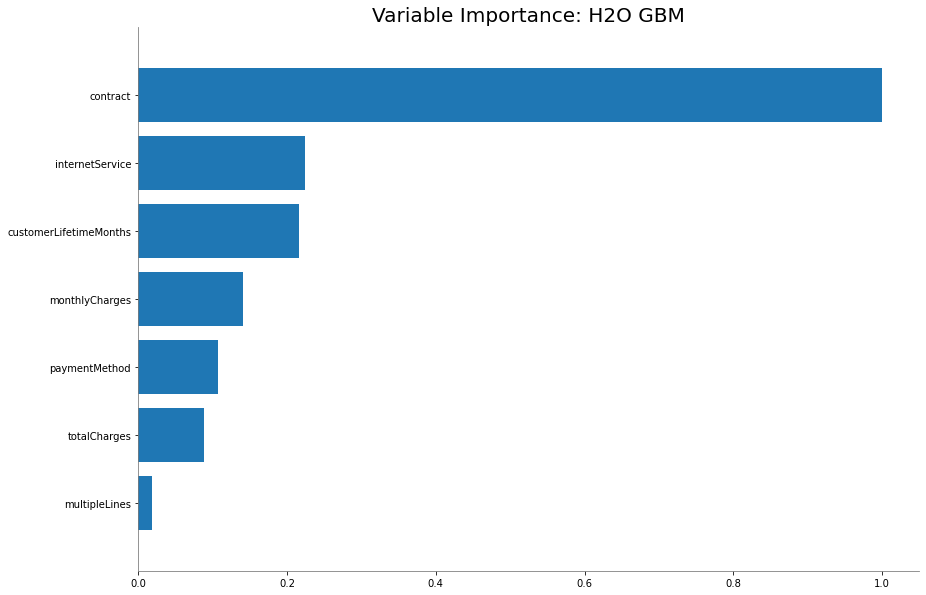

In [34]:
best_gbm_max_depth.varimp_plot()

In [35]:
# save the model
h2o.save_model(best_gbm_max_depth)

'D:\\Bea\\Projects\\telco_customer_churn\\Grid_GBM_py_2_sid_9f00_model_python_1585656568205_1021_model_1'

# VI. Which customers are less loyal?¶
As we saw during the EDA and what we can confirm with the model is that the less loyal customers are the following:

- the ones who has month-to-month contracts

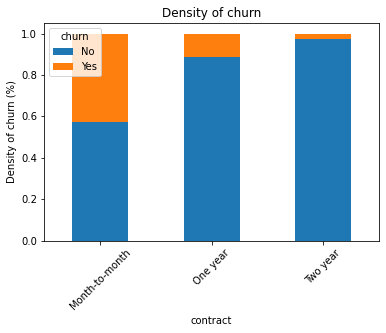

In [36]:
ut.plot_full_stacked_density(df, 'churn', 'contract', 'bar')


- the customers with lower customer lifetimes

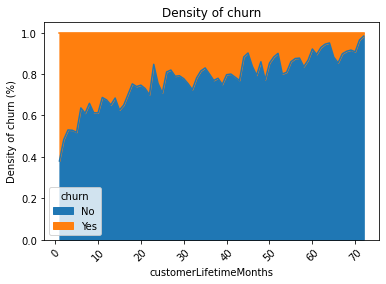

In [37]:
ut.plot_full_stacked_density(df, 'churn', 'customerLifetimeMonths', 'area')

* the ones with internet services, mainly with Fiber optic service

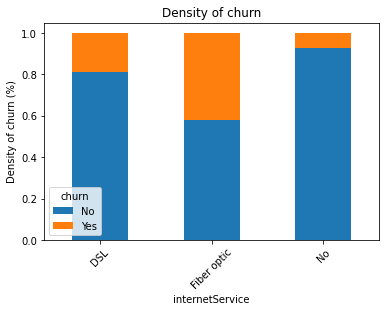

In [38]:
ut.plot_full_stacked_density(df, 'churn', 'internetService', 'bar')

# II. Proposals for later projects
- split the customer base based on the contract type into month-to-month and other customers and build one model for each of these customer bases
- it would be nice to have more data about the customers:
    * dates
        - so we can create analyis on a monthly basis as well
        - we could take seasonality into consideration
    * usage data
        - general usage
        - were there any day in the last 3 or 6 months when he/she did not use his/her phone/internet service at all?
        - can we see a decreasing tendency in the general usage data?
    * phone usage
        - minutes spoken per day/week/month
    * internet usage
        - Mb internet used per day/week/month
    * social data - data about the most frequent partners
        - how long do they usually speak with each other?
        - who calls who more often?
        - how many times do they speak per week/month?
        - did any of them churn lately?
